In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import poisson

# Jack's Car Rental

In this notebook, we'll be reimplementing a solution to the Jack's Car Rental problem given in Example 4.2 of Chapter 4 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) by Richard Sutton and Andrew Barto. In addition to implementing a solution to the original problem, we will also answer the associated exercise questions.

## Initial solution

The initial problem setup is that Jack's Car Rental has two locations, each of which has a different demand for rentals and rate of rentals being returned to that location. After the businesses close each night, Jack can pay to shuttle cars from one location to another. The goal here is to find the optimal number of cars to shuttle between the two locations given the number of cars at each location at the end of the business day.

In particular, the number of rentals and returns per day at each location are Poisson distributed with a mean of 3 rentals and 3 returns at the first location, and 4 rentals and 2 returns at the second location. Jack makes \\$10 for each car he can rent on a given day (rental requests in excess of the number of cars available are unfulfilled and are missed sales), and pays \\$2 per car to shuttle overnight. Jack can also only move a maximum of 5 cars per night, and each location can hold at most 20 cars, any excess cars are imagined to be shuttled off to some other locations for the national chain.

To map this problem statement to the reinforcement learning terminology, the number of cars at each location the end of the day is the state, the actions are the number of cars to shuttle overnight, the reward is the net profit for the day, and the policy is then how many cars to shuttle given a particular number of cars at each location to maximize the profit.

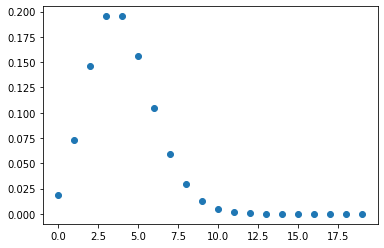

In [2]:
# Since we have Poisson random variables here, which theoretically could
# lead to an infinite number of cars being rented or returned, we want to
# understand what's a reasonable number of rentals or returns with
# non-trivial probability to use as a maximum for our calculations.
# Based on the plot below, 14 seems reasonable.
x = np.arange(0, 20)
y = poisson.pmf(x, 4)
plt.scatter(x, y)

In [3]:
# Maximum number of cars per location.
max_cars = 20
# Actual dimension of state matrix (since we can also have 0 cars).
d = max_cars+1
# Maximum number of cars we can move per night.
max_move = 5
# Maximum value of number of rentals and returns to consider.
max_poisson = 14

# Mean number of rentals and returns per location.
loc1_rent_mean = 3
loc1_return_mean = 3
loc2_rent_mean = 4
loc2_return_mean = 2

# Reward for rentals.
rent_reward = 10
# Cost for moving a car overnight.
move_cost = -2
# Discount factor.
gamma = 0.9

In order to use policy iteration to solve this problem, we need to be able to write down the probability of transitioning from one state to another. Since the number of rentals and returns are a random variable, there are multiple numbers of rentals and returns that can result in the same state transition. For example, we could go from 15 cars to 12 cars as a result of 3 rentals and 0 returns, 4 rentals and 1 return, etc. Since each of these numbers of rentals/returns have a different probability (coming from the Poisson distribution), we want to sum the probability of all the combinations to get the total probabilty of a given state transition. Since these probabilities aren't changing over time, we can precompute them to speed up our policy iteration process.

In addition to precomputing the state transition probabilities over some grid of reasonable rental/return values, we can also precompute the expected reward coming from rentals alone, since this is only a function of the number of cars (i.e. the state) and the distribution of the number of rentals/returns (which we know). We can then add in the cost associated with our action when we actually perform the policy iteration process.

These transition probabilities and expected rewards will be stored in a 4D array, where the first and second dimensions are the current state and the third and fourth dimensions are the future state: [curr_cars_loc1, curr_cars_loc2, next_cars_loc1, next_cars_loc2]

In [4]:
# Precompute Poisson PMF out to the maximum amount.
def populatePoisLookup(mean, max_val=max_poisson):
    return poisson(mean).pmf(np.arange(max_val+1))

loc1_rent_dist = populatePoisLookup(loc1_rent_mean)
loc1_return_dist = populatePoisLookup(loc1_return_mean)
loc2_rent_dist = populatePoisLookup(loc2_rent_mean)
loc2_return_dist = populatePoisLookup(loc2_return_mean)

In [60]:
# Calculate transition probabilities and expected rewards for each
# possible state given a current state.
def calculate_one_state(curr_loc1, curr_loc2):
    expected_reward = np.zeros((d, d))
    transition_prob = np.zeros((d, d))
    
    # Iterate over number of rentals and returns at each location,
    # capping the number of rentals to be at most the number of cars
    # at the location, and capping the final number of cars after returns
    # to be at most `max_cars`.
    for rent1 in range(max_poisson):
        for rent2 in range(max_poisson):
            # Probabilities of number of rental requests at each location.
            p_rent1 = loc1_rent_dist[rent1]
            p_rent2 = loc2_rent_dist[rent2]

            # Number of cars actually rented (i.e. at most the number
            # of available cars). Note that cars become available for
            # rent the next day, so we don't include the number of returns
            # in the number of cars available for rent.
            actual_rent1 = min(rent1, curr_loc1)
            actual_rent2 = min(rent2, curr_loc2)
            
            for return1 in range(max_poisson):
                for return2 in range(max_poisson):
                    # Probabilities of number of returns.
                    p_return1 = loc1_return_dist[return1]
                    p_return2 = loc2_return_dist[return2]
                    
                    # What's the state we end up in after this number of 
                    # rentals and returns, capped at being at most the
                    # maximum number of cars per location.
                    future_loc1 = min(curr_loc1 + return1 - actual_rent1, max_cars)
                    future_loc2 = min(curr_loc2 + return2 - actual_rent2, max_cars)

                    # Total probability of this number of rental requests
                    # and returns at both locations.
                    total_p = p_rent1*p_rent2*p_return1*p_return2
                    # Actual reward from rentals.
                    reward = (actual_rent1 + actual_rent2)*rent_reward

                    # Add the transition probability and probability-weighted
                    # reward for the future state for this specific combination
                    # of rentals and returns.
                    transition_prob[future_loc1, future_loc2] += total_p
                    expected_reward[future_loc1, future_loc2] += total_p*reward
            
    return transition_prob, expected_reward

# Calculate transition probabilities and expected rewards for every combination 
# of current state and future state.
def calculate_all_states(calculate_fn=calculate_one_state):
    expected_reward = np.zeros((d, d, d, d))
    transition_prob = np.zeros((d, d, d, d))
    for curr_loc1, curr_loc2 in np.ndindex((d, d)):
        p, r = calculate_one_state(curr_loc1, curr_loc2)
        
        # Since `p` represents the probability of transitioning to any other
        # possible state from (curr1, curr2), good to sanity check that total
        # probability is close to 1 despite our simplification of only considering
        # at most 14 rentals/returns.
        assert(1 - p.sum() < 1e-4)
        
        transition_prob[curr_loc1, curr_loc2] = p       
        expected_reward[curr_loc1, curr_loc2] = r
        
    return transition_prob, expected_reward

In [6]:
transition_probs, expected_rewards = calculate_all_states()

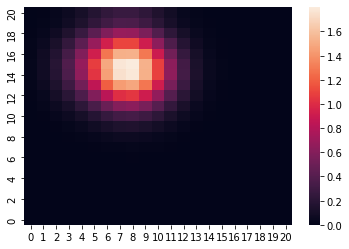

In [7]:
ax = sns.heatmap(expected_rewards[15,10])
ax.invert_yaxis()

In [14]:
expected_rewards[15,10, 10:18, 4:10]

array([[0.10861078, 0.17725822, 0.25349282, 0.31290248, 0.32863131,
        0.28986085],
       [0.21265116, 0.34542909, 0.49142778, 0.60315688, 0.62962427,
        0.55186647],
       [0.36121306, 0.58377641, 0.82581004, 1.00720627, 1.04425394,
        0.90879519],
       [0.52586341, 0.84532533, 1.18856398, 1.43981349, 1.48164855,
        1.27927709],
       [0.64885542, 1.03735242, 1.4494834 , 1.74347646, 1.7799898 ,
        1.52383562],
       [0.67316997, 1.0705712 , 1.48681699, 1.77588742, 1.79873879,
        1.52656734],
       [0.58592217, 0.9273782 , 1.28078075, 1.51987098, 1.52795994,
        1.28602463],
       [0.42986175, 0.67756493, 0.93121616, 1.09871402, 1.09718905,
        0.91650781]])

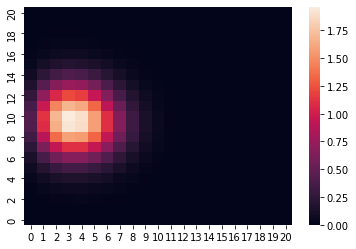

In [8]:
ax = sns.heatmap(expected_rewards[10,6])
ax.invert_yaxis()

In [56]:
# Actual policy iteration code. As in Sutton, we implement the policy
# as a matrix of values where the value indicates the number of cars
# to move from location 1 to location 2 and a negative value indicates
# instead moving cars from location 2 to location 1.

# Calculate the state value function for a single state given
# our current action at this state.
def backup_one(value_fn, num_move, curr_loc1, curr_loc2):
    curr1_after_move = min(curr_loc1 - num_move, max_cars)
    curr2_after_move = min(curr_loc2 + num_move, max_cars)
    
    val = 0
    for future_loc1, future_loc2 in np.ndindex(value_fn.shape):
        r = expected_rewards[curr1_after_move, curr2_after_move,
                             future_loc1, future_loc2]
        p = transition_probs[curr1_after_move, curr2_after_move,
                             future_loc1, future_loc2]
        
        # Note that the expected reward is already weighted by the
        # appropriate probabilities of rentals/returns, so it's excluded
        # from being multiplied by the state transition probability here.
        this_reward = r + p * gamma * value_fn[future_loc1, future_loc2]
        val += this_reward

    # Add in cost from moving cars.
    return val + np.abs(num_move)*move_cost

# Run one round of in-place policy evaluation until convergence.
def evaluate(value_fn, policy, backup_fn=backup_one):
    # Store state-value function before policy evaluation so we
    # can see if current policy is equivalent to previous one by
    # checking the delta for all states. Note that this also answers
    # exercise 4.4 (see below for explanation).
    prev_value_fn = np.copy(value_fn)
    
    # Iterate value function evaluation until delta is sufficiently small.
    while True:
        iter_delta = 0
        for curr_loc1, curr_loc2 in np.ndindex(value_fn.shape):
            new_val = backup_fn(value_fn,
                                 policy[curr_loc1, curr_loc2],
                                 curr_loc1,
                                 curr_loc2)
            iter_delta = max(np.abs(new_val - value_fn[curr_loc1, curr_loc2]),
                        iter_delta)

            value_fn[curr_loc1, curr_loc2] = new_val
       # break
        if iter_delta <= 1e-4:
            break
            
    # Check if new policy is equivalent to previous.
    return np.all(np.isclose(prev_value_fn, value_fn))

# Run one round of policy improvement using greedy best move.
def iterate(value_fn, policy, backup_fn=backup_one):
    # Identify greedy best move for each state. Also check if the policy
    # is stable.
    is_stable = True
    for curr_loc1, curr_loc2 in np.ndindex(value_fn.shape):
        best_move = 0
        best_val = 0
        for num_move in np.arange(-max_move, max_move+1):
            # Ignore moves that exceed the number of available cars.
            if num_move > curr_loc1 or -num_move > curr_loc2:
                continue
            
            # Expected reward for taking this action from this state.
            check_val = backup_fn(value_fn, num_move, curr_loc1, curr_loc2)
            
            if check_val > best_val:
                best_val = check_val
                best_move = num_move
                
        if best_move != policy[curr_loc1, curr_loc2]:
            is_stable = False
        policy[curr_loc1, curr_loc2] = best_move
    return is_stable

def policy_iteration(backup_fn=backup_one):
    value_fn = np.zeros((d, d))
    policy = np.zeros((d, d), dtype=int)
    
    i = 0
    while True:
        is_equiv = evaluate(value_fn, policy, backup_fn=backup_fn)
        stable_policy = iterate(value_fn, policy, backup_fn=backup_fn)
        print(f"iter {i}: is_equiv={is_equiv}, stable={stable_policy}")
        i += 1
        if stable_policy or is_equiv:
            break
    return value_fn, policy

In [57]:
optimal_v, optimal_p = policy_iteration()

iter 0: is_equiv=False, stable=False
iter 1: is_equiv=False, stable=False
iter 2: is_equiv=False, stable=False
iter 3: is_equiv=False, stable=False
iter 4: is_equiv=False, stable=False
iter 5: is_equiv=True, stable=True


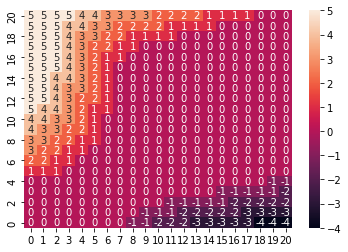

In [58]:
ax = sns.heatmap(optimal_p, annot=True)
ax.invert_yaxis()

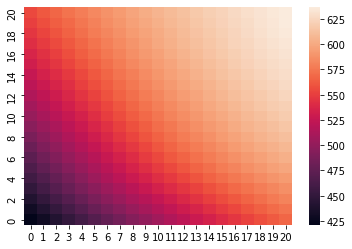

In [59]:
ax = sns.heatmap(optimal_v)
ax.invert_yaxis()

While our exact optimal policy seems as if it differs from that shown in figure 4.2 of the textbook (somewhat hard to tell since we have to guess based off rectangle widths), the overall shape of the policy contours look correct and the final state-value function has the same shape and scale.

## Exercise 4.4

Note our modification in the policy evaluation step: check if the optimal state-value function for this policy is equal (within some epsilon) to the previous one at all states. By the policy improvement theorem, we know that our state-value function will be strictly increasing throughout the policy iteration process, so if we reach two policies that have equal state-value functions, then we know that both policies are optimal (can also see pg 79 of the textbook for more details).

## Exercise 4.5

## Exercise 4.7

One of Jack’s employees at the first location
rides a bus home each night and lives near the second location. She is happy to shuttle
one car to the second location for free. Each additional car still costs $2, as do all cars
moved in the other direction. In addition, Jack has limited parking space at each location.
If more than 10 cars are kept overnight at a location (after any moving of cars), then an
additional cost of \\$4 must be incurred to use a second parking lot (independent of how
many cars are kept there). 

In [61]:
# Calculate transition probabilities and expected rewards for each
# possible state given a current state.
def calculate_one_state_47(curr_loc1, curr_loc2):
    expected_reward = np.zeros((d, d))
    transition_prob = np.zeros((d, d))
    
    # Iterate over number of rentals and returns at each location,
    # capping the number of rentals to be at most the number of cars
    # at the location, and capping the final number of cars after returns
    # to be at most `max_cars`.
    for rent1 in range(max_poisson):
        for rent2 in range(max_poisson):
            # Probabilities of number of rental requests at each location.
            p_rent1 = loc1_rent_dist[rent1]
            p_rent2 = loc2_rent_dist[rent2]

            # Number of cars actually rented (i.e. at most the number
            # of available cars). Note that cars become available for
            # rent the next day, so we don't include the number of returns
            # in the number of cars available for rent.
            actual_rent1 = min(rent1, curr_loc1)
            actual_rent2 = min(rent2, curr_loc2)
            
            for return1 in range(max_poisson):
                for return2 in range(max_poisson):
                    # Probabilities of number of returns.
                    p_return1 = loc1_return_dist[return1]
                    p_return2 = loc2_return_dist[return2]
                    
                    # What's the state we end up in after this number of 
                    # rentals and returns, capped at being at most the
                    # maximum number of cars per location.
                    future_loc1 = min(curr_loc1 + return1 - actual_rent1, max_cars)
                    future_loc2 = min(curr_loc2 + return2 - actual_rent2, max_cars)

                    # Total probability of this number of rental requests
                    # and returns at both locations.
                    total_p = p_rent1*p_rent2*p_return1*p_return2
                    # Actual reward from rentals.
                    reward = (actual_rent1 + actual_rent2)*rent_reward
                    
                    # Storage penalty of $4 per location if more than 10 cars.
                    if future_loc1 > 10:
                        reward -= 4
                    if future_loc2 > 10:
                        reward -= 4

                    # Add the transition probability and probability-weighted
                    # reward for the future state for this specific combination
                    # of rentals and returns.
                    transition_prob[future_loc1, future_loc2] += total_p
                    expected_reward[future_loc1, future_loc2] += total_p*reward
            
    return transition_prob, expected_reward

In [62]:
transition_prob_47, expected_rewards_47 = calculate_all_states(calculate_fn=calculate_one_state_47)

In [69]:
# Calculate the state value function for a single state given
# our current action at this state.
def backup_one_47(value_fn, num_move, curr_loc1, curr_loc2):
    curr1_after_move = min(curr_loc1 - num_move, max_cars)
    curr2_after_move = min(curr_loc2 + num_move, max_cars)
    
    val = 0
    for future_loc1, future_loc2 in np.ndindex(value_fn.shape):
        r = expected_rewards_47[curr1_after_move, curr2_after_move,
                             future_loc1, future_loc2]
        p = transition_prob_47[curr1_after_move, curr2_after_move,
                             future_loc1, future_loc2]
        
        # Note that the expected reward is already weighted by the
        # appropriate probabilities of rentals/returns, so it's excluded
        # from being multiplied by the state transition probability here.
        this_reward = r + p * gamma * value_fn[future_loc1, future_loc2]
        val += this_reward

    # Add in cost from moving cars.
    move_penalty = np.abs(num_move)*move_cost
    # If moving cars from first location to second location,
    # then one car moves for free.
    if num_move >= 1:
        move_penalty -= move_cost
        
    return val + move_penalty

In [70]:
optimal_v_47, optimal_p_47 = policy_iteration(backup_fn=backup_one_47)

iter 0: is_equiv=False, stable=False
iter 1: is_equiv=False, stable=False
iter 2: is_equiv=False, stable=False
iter 3: is_equiv=False, stable=False
iter 4: is_equiv=False, stable=True


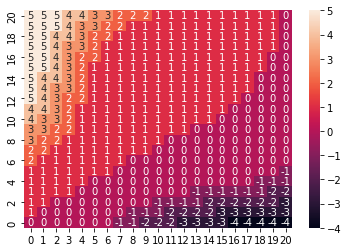

In [71]:
ax = sns.heatmap(optimal_p_47, annot=True)
ax.invert_yaxis()

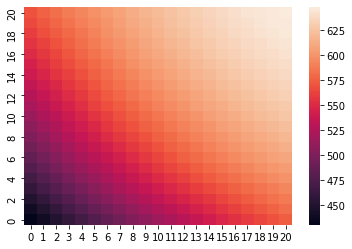

In [72]:
ax = sns.heatmap(optimal_v_47)
ax.invert_yaxis()

# Gambler's Problem

## Initial solution

In [147]:
end_val = 100
p_heads = 0.4
p_tails = 1-p_heads

In [148]:
def calc_wager_value(value_fn, state, wager):
    win_state = state + wager
    lose_state = state - wager

    return p_tails*value_fn[lose_state] + p_heads*value_fn[win_state]

def single_iterate(value_fn):
    max_delta = 0
    for state in reversed(np.arange(end_val)):
        
        possible_wagers = np.arange(0, min(state, end_val-state)+1)
        
        max_val = 0
        for w in possible_wagers:
            val = calc_wager_value(value_fn, state, w)
            if val > max_val:
                max_val = val
                
        this_delta = np.abs(max_val - value_fn[state])
        if this_delta > max_delta:
            max_delta = this_delta
            
        value_fn[state] = max_val
    return max_delta

def value_iterate():
    value_fn = np.zeros(end_val+1)
    value_fn[end_val] = 1
    
    i = 0
    while True:
        delta = single_iterate(value_fn)
        print(f"iter {i}: {delta:0.4f}")
        
        if delta < 1e-6:
            break
        i += 1
    return value_fn

def policy_from_value(value_fn):
    policy = np.zeros(end_val)
    for state in np.arange(end_val):
        best_val = 0
        best_wager = 0
        for wager in  np.arange(0, min(state, end_val-state)+1):
            wager_val = calc_wager_value(value_fn, state, wager)
            if (wager_val - best_val) > 1e-7:
                best_val = wager_val
                best_wager = wager
        policy[state] = best_wager
    return policy

# def policy_from_value_book_figure(value_fn):
#     policy = np.zeros(end_val)
#     for state in np.arange(end_val):
#         best_val = 0
#         best_wager = 0
#         for wager in reversed(np.arange(0, min(state, end_val-state)+1)):
#             wager_val = calc_wager_value(value_fn, state, wager)
#             if np.abs(best_val - wager_val) < 1e-6:
#                     if wager_val
#             if wager_val > best_val:
#                 best_val = wager_val
#                 best_wager = wager
#         policy[state] = best_wager
#     return policy

In [149]:
final_v = value_iterate()

iter 0: 0.4000
iter 1: 0.2400
iter 2: 0.1440
iter 3: 0.0864
iter 4: 0.0518
iter 5: 0.0311
iter 6: 0.0075
iter 7: 0.0025
iter 8: 0.0008
iter 9: 0.0002
iter 10: 0.0000
iter 11: 0.0000
iter 12: 0.0000


In [156]:
final_v[2]

0.00516406192632278

In [151]:
calc_wager_value(final_v, 51, 49)

0.4030984371557937

In [153]:
calc_wager_value(final_v, 51, 1)

0.40309843714587545

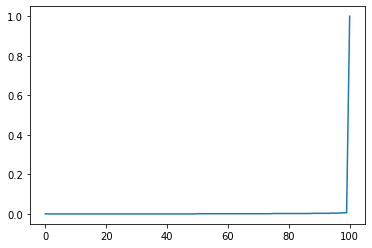

In [132]:
plt.plot(np.arange(end_val+1), final_v)

In [133]:
final_v[27:33]

array([1.00000000e-06, 1.00000000e-06, 1.00000100e-06, 1.00000200e-06,
       1.00000399e-06, 1.00099900e-06])

In [134]:
policy = policy_from_value(final_v)

In [135]:
policy

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

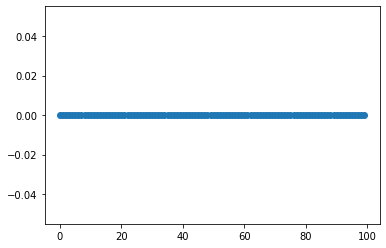

In [136]:
plt.scatter(np.arange(end_val), policy)

In [181]:
0.6*final_v[0] + 0.4*final_v[100]

0.4

In [182]:
final_v[50]

0.4

In [284]:
calc_wager_value(final_v, 51, 49)

0.4030984371557937

In [285]:
calc_wager_value(final_v, 51, 1)

0.40309843714587545

In [286]:
calc_wager_value(final_v, 51, 0)

0.40309843714587545

In [ ]:
    for state in np.arange(end_val):
        best_val = 0
        best_wager = 0
        for wager in  np.arange(0, min(state, end_val-state)+1):
            wager_val = calc_wager_value(value_fn, state, wager)
            if wager_val > best_val:
                best_val = wager_val
                best_wager = wager
        policy[state] = best_wager
    return policy

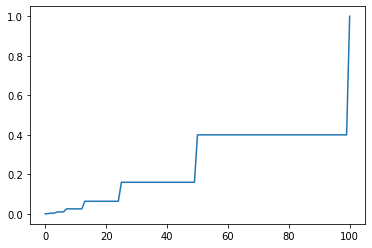

In [84]:
plt.plot(np.arange(end_val+1), value_fn)

In [777]:
def expected_return_debug(state, action, state_value, constant_returned_cars, check1, check2):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)
    
    check_p = 0
    check_r = 0
    n_checked = 0

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
                        
                        if num_of_cars_first_loc_ == check1 and num_of_cars_second_loc_ == check2:
                            check_p += prob_
                            check_r += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
                            n_checked += 1
                            print(rental_request_first_loc, rental_request_second_loc,
                                  returned_cars_first_loc, returned_cars_second_loc,
                                  prob_, reward,  state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    print(check_p, check_r, n_checked)
    return returns

/var/folders/rw/wj50zblj7kjcn35zy9wm2lpr0000gp/T/ipykernel_1580/3486407517.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  policy = np.zeros(value.shape, dtype=np.int)


max value change 191.14044425450055
max value change 131.91909180411542
max value change 88.61937127296514
max value change 66.27613430095826
max value change 52.30404034617686
max value change 40.50431282688453
max value change 31.571819689709855
max value change 25.009002907688057
max value change 20.776212359973954
max value change 17.373214856382333
max value change 14.489145965680734
max value change 12.054381189472622
max value change 10.005913044444071
max value change 8.288060588890005
max value change 6.851978596679828
max value change 5.654991085770007
max value change 4.659991030583512
max value change 3.8349060091838396
max value change 3.1521952447087074
max value change 2.588360954112318
max value change 2.1234741080097024
max value change 1.7407223622981292
max value change 1.4259887280390444
max value change 1.1674672474201202
max value change 0.9553189041116639
max value change 0.7813683111010619
max value change 0.638839739487878
max value change 0.5221297762513473
ma

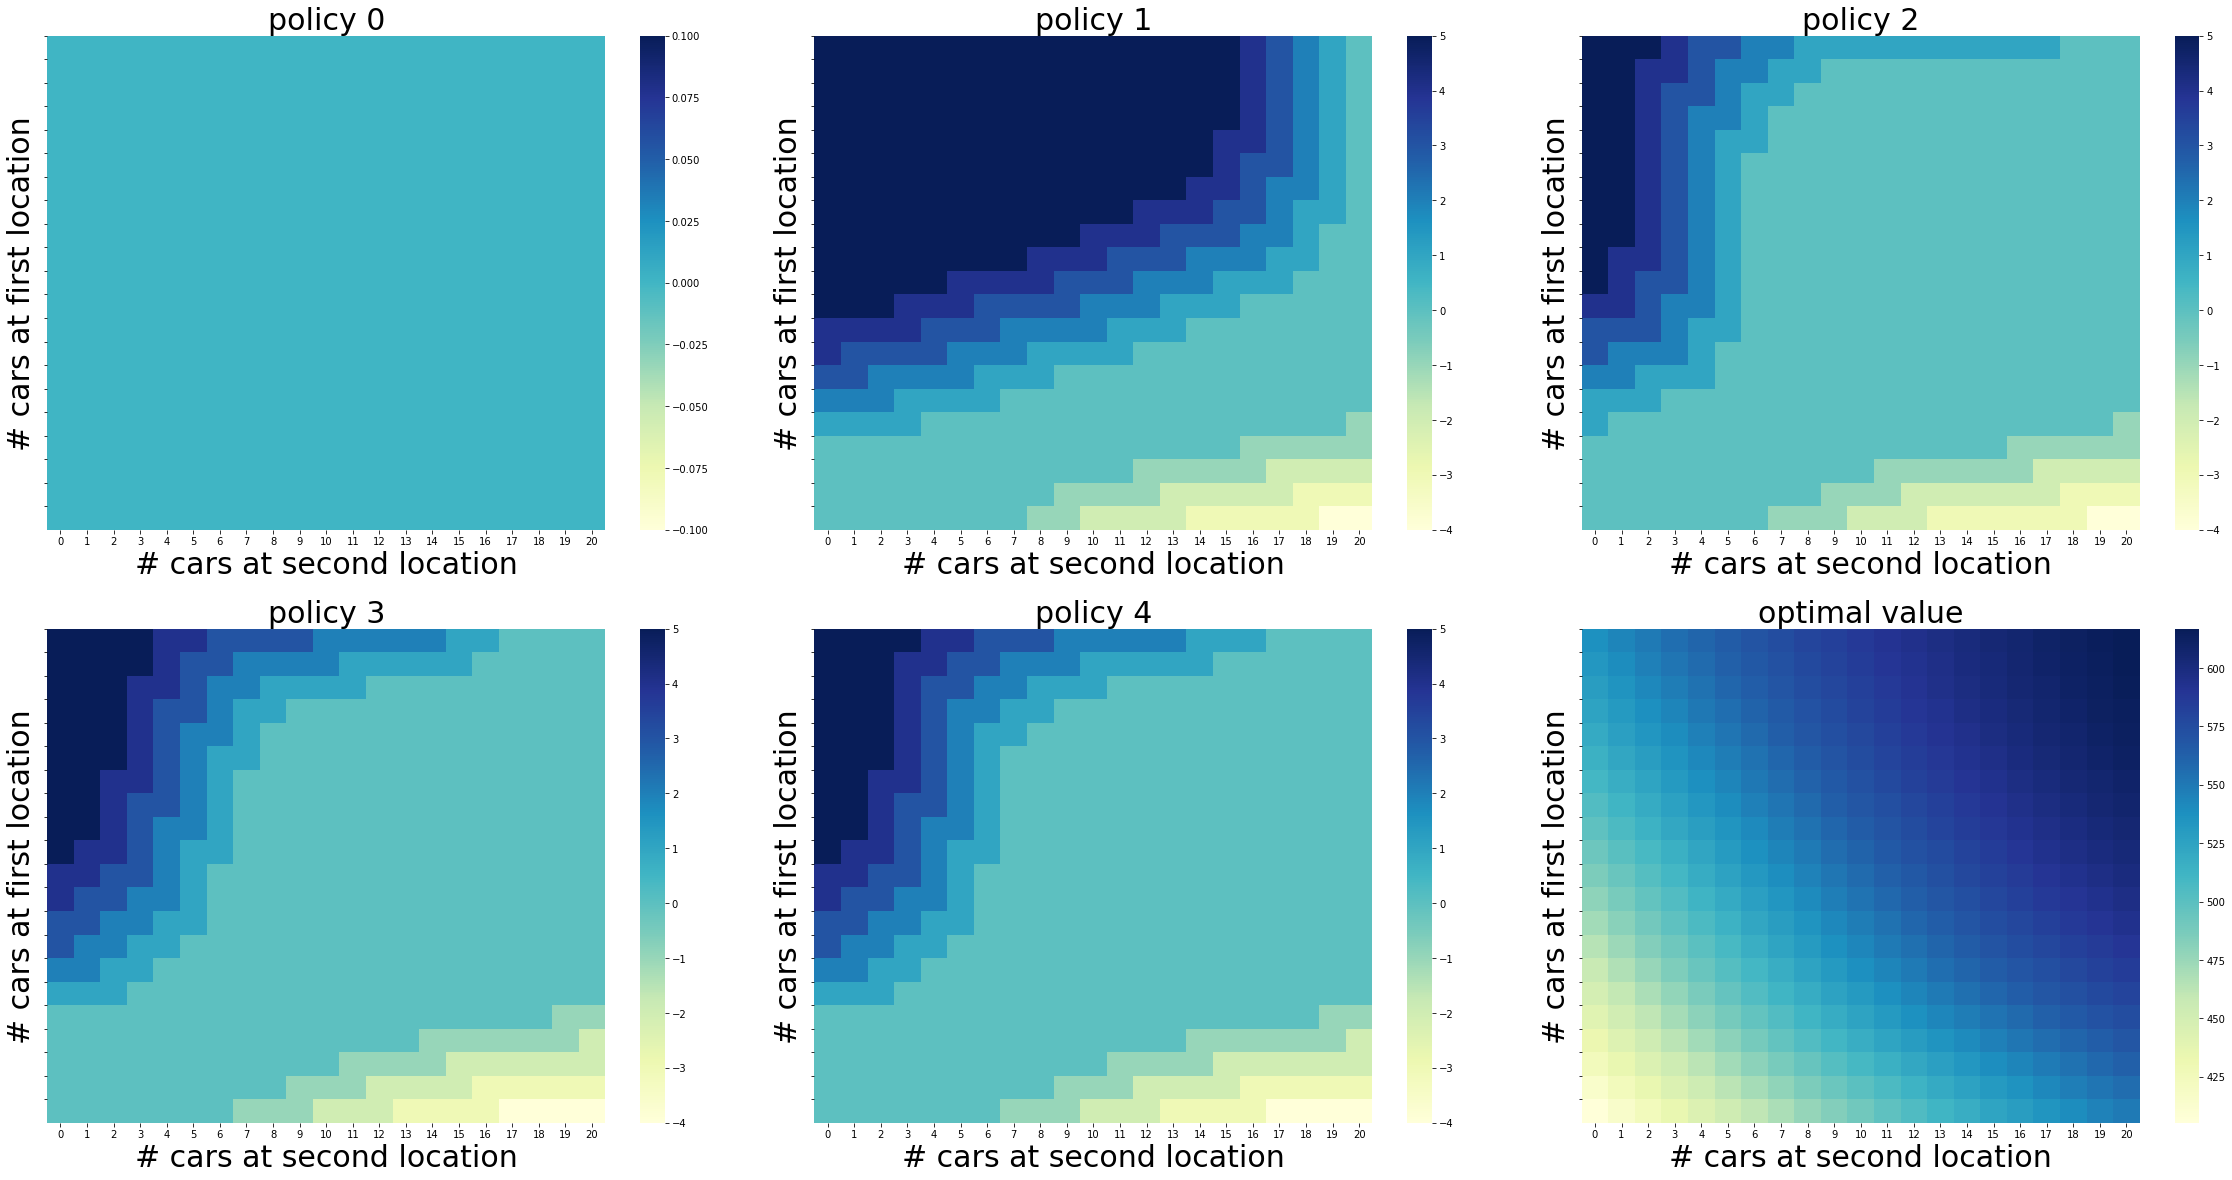

In [781]:
ref_v, ref_p = figure_4_2(constant_returned_cars=False)

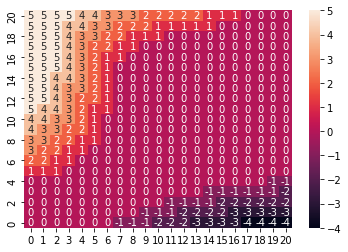

In [795]:
ax = sns.heatmap(p, annot=True)
ax.invert_yaxis()

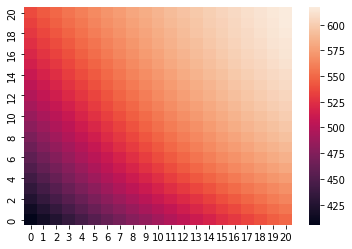

In [797]:
ax = sns.heatmap(v)
ax.invert_yaxis()